<a href="https://colab.research.google.com/github/costanzagiacona/Progetto-ML/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image classification**
Machine learning project for image classification using different types of models. I used 'MedMNIST-Pneumonia' data set for training.
The aim of this project is to train and evaluate one or more classification models in order to establish if the lungs in the images have pneumonia or not.

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


Cell that groups all the libraries used for this project

In [ ]:
import numpy as np                           # For numerical operations
import pandas as pd                          # For data manipulation and analysis
import matplotlib.pyplot as plt              # For data visualization
import seaborn as sns                        # For enhanced data visualization
import time                                  # For timing operations
import random

# Imports for data manipulation and model preparation
from sklearn.model_selection import train_test_split, GridSearchCV     # For splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder        # For preprocessing data
from sklearn.impute import SimpleImputer                               # For handling missing values
from sklearn.pipeline import make_pipeline                             # For creating pipelines
from sklearn.compose import make_column_transformer                     # For transforming columns in datasets
from sklearn.model_selection import StratifiedShuffleSplit              # For stratified splitting of data
from sklearn.metrics import mean_squared_error, mean_absolute_error    # For model evaluation
from sklearn.linear_model import LinearRegression, LogisticRegression  # For linear and logistic regression
from sklearn.tree import DecisionTreeRegressor                         # For decision tree regression
from sklearn.neighbors import KNeighborsRegressor                      # For KNN regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  # For random forest models
from sklearn.svm import SVC                                           # For Support Vector Classifier
from sklearn.decomposition import PCA                                  # For Principal Component Analysis
from sklearn.metrics import accuracy_score                            # For accuracy

# Imports for visualization and presenting results
from IPython.display import Markdown, display                          # For displaying Markdown and results
import seaborn as sns                                                  # For advanced visualization
from pandas.plotting import scatter_matrix                             # For plotting scatter matrix
from glob import glob                                                  # For displaying images
from PIL import Image
import os
import cv2                                                             # For filtering images

# Imports for modeling with Keras
import tensorflow as tf                                                 # TensorFlow library
from tensorflow import keras                                            # Keras API for TensorFlow
import keras_tuner                                                      # Keras Tuner for hyperparameter tuning
from keras.models import Sequential                                     # For sequential models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D  # For defining layers


I loaded the dataset. The images are stored in the file 'pneumonia_images' and the labels in 'pneumonia_labels'.

In [ ]:
# Uploading dataset
try:
    X = np.load("/content/drive/MyDrive/pneumonia_images.npy")
    y = np.load("/content/drive/MyDrive/pneumonia_labels.npy")
except FileNotFoundError:
    print("File not found. Make sure you have the correct path")
    exit()

This code snippet counts the number of normal and pneumonia images, displays a sample of each class, and shows the class distribution.

Image shape: (28, 28)
Total normal images: 1349
Total pneumonia images: 3883


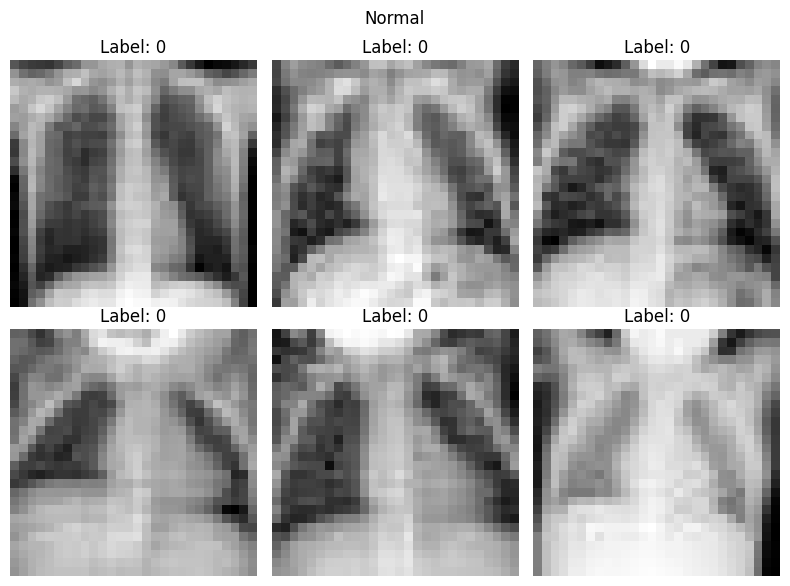

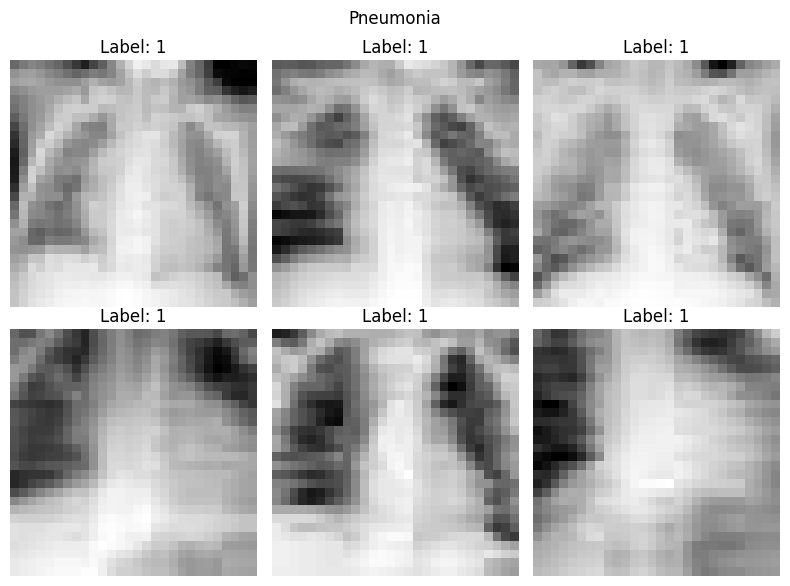

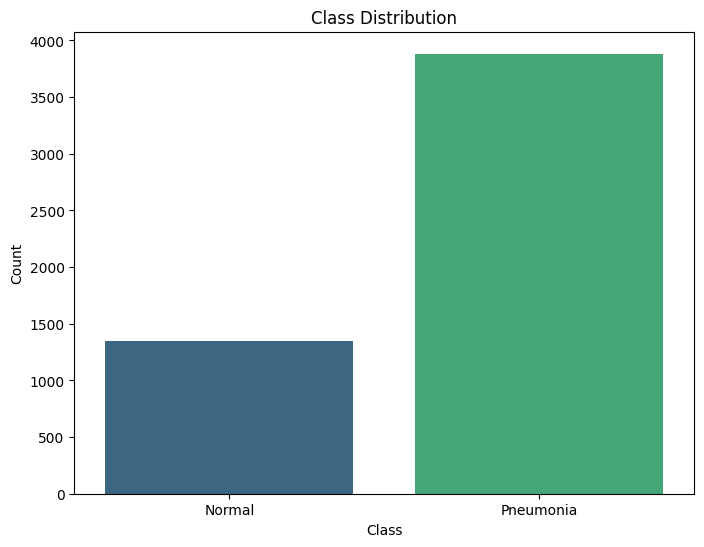

In [ ]:
# Check the resolution of images
print(f'Image shape: {X[0].shape}')

# Count the number of images in each class
normal_images_count = np.sum(y == 0)
pneumonia_images_count = np.sum(y == 1)

print(f'Total normal images: {normal_images_count}')
print(f'Total pneumonia images: {pneumonia_images_count}')

# Function to display some images
def show_images(images, labels, label, title):
    plt.figure(figsize=(8,6))
    indices = np.where(labels == label)[0][:6]  # Get the first 6 indices of the specified label
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display some normal images
show_images(X, y, 0, 'Normal')

# Display some pneumonia images
show_images(X, y, 1, 'Pneumonia')

# Distribution of classes
labels = ['Normal', 'Pneumonia']
counts = [normal_images_count, pneumonia_images_count]
data = pd.DataFrame({'Class': labels, 'Count': counts})

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=data, palette='viridis', hue='Class', dodge=False, legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

I randomly split the dataset into a training set, validation set and a test set; the training set is used to train the different models, the validation set to calculate the errors on new predictions and the test set to verify again the performance of the best models on new data. The split I used is approximately: 70% training set, 15% validation set and 15% test set.

I used the function train_test_split, offered by Scikit-learn for this task, to do a first split of the data and then I did a second split of the training set to create all the three sets. I also joined the x_train and y_train to create the training set.

In [ ]:
# Division of dataset in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Make sure the labels are in the correct format
y_train = y_train.ravel()
y_validation = y_validation.ravel()
y_test = y_test.ravel()

In [ ]:
# If the images are garyscale, add a channel
X_train = np.expand_dims(X_train, axis=-1)
X_validation = np.expand_dims(X_validation, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
print("Training set dimension:", X_train.shape)
print("Data type:", X_train.dtype)
num_samples, height, width, channels = X_train.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)

Training set dimension: (3662, 28, 28, 1)
Data type: uint8
Number of samples: 3662
Image height: 28
Image width: 28
Image number of channels: 1


Try to apply some filters to the images. The blurr can help identifying better the features.

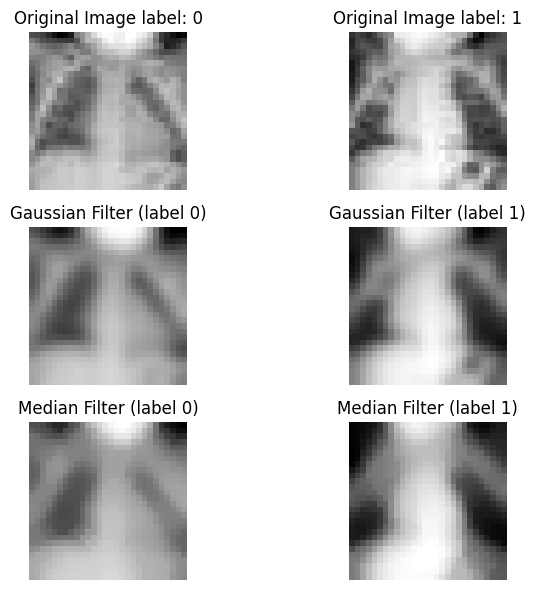

In [ ]:
# Randomly select an image with label 0
index_label_0 = random.choice(np.where(y == 0)[0])
image_label_0 = X[index_label_0]

# Randomly select an image with label 1
index_label_1 = random.choice(np.where(y == 1)[0])
image_label_1 = X[index_label_1]

# Apply Gaussian blur filter for noise reduction
blurred_image_0 = cv2.GaussianBlur(image_label_0, (5, 5), 0)
blurred_image_1 = cv2.GaussianBlur(image_label_1, (5, 5), 0)

# Apply median blur filter for noise reduction
median_filtered_image_0 = cv2.medianBlur(blurred_image_0, 5)
median_filtered_image_1 = cv2.medianBlur(blurred_image_1, 5)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 6))

# First row: original images
axes[0, 0].imshow(image_label_0, cmap='gray')
axes[0, 0].set_title('Original Image label: 0')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_label_1, cmap='gray')
axes[0, 1].set_title('Original Image label: 1')
axes[0, 1].axis('off')

# Second row: images with Gaussian filter
axes[1, 0].imshow(blurred_image_0, cmap='gray')
axes[1, 0].set_title('Gaussian Filter (label 0)')
axes[1, 0].axis('off')

axes[1, 1].imshow(blurred_image_1, cmap='gray')
axes[1, 1].set_title('Gaussian Filter (label 1)')
axes[1, 1].axis('off')

# Third row: images with median filter
axes[2, 0].imshow(median_filtered_image_0, cmap='gray')
axes[2, 0].set_title('Median Filter (label 0)')
axes[2, 0].axis('off')

axes[2, 1].imshow(median_filtered_image_1, cmap='gray')
axes[2, 1].set_title('Median Filter (label 1)')
axes[2, 1].axis('off')

# Adjust the layout of the subplots to optimize spacing
plt.tight_layout()
plt.show()

# **Support** **Vector** **Machine**

In [ ]:
# SVM model
svm_model = SVC(random_state=42)
svm_param_grid = {'C': [1], 'kernel': ['rbf']}
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy')

start_time = time.time()
svm_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
end_time = time.time()

svm_model_best = svm_grid_search.best_estimator_
svm_pred = svm_model_best.predict(X_validation.reshape(len(X_validation), -1))
svm_accuracy = accuracy_score(y_validation, svm_pred)

# Calculation of RMSE
svm_rmse = mean_squared_error(y_validation, svm_pred, squared=False)

# Processing time
svm_processing_time = end_time - start_time


In [ ]:
# Print performance
print("Miglior modello SVM:")
print(svm_model_best)
print("Accuracy SVM (validation):", svm_accuracy)
print("Confusion Matrix SVM:")
print(confusion_matrix(y_validation, svm_pred))
print("Classification Report SVM:")
print(classification_report(y_validation, svm_pred))

Miglior modello SVM:
SVC(C=1, random_state=42)
Accuracy SVM (validation): 0.9528662420382166
Confusion Matrix SVM:
[[193  27]
 [ 10 555]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       220
           1       0.95      0.98      0.97       565

    accuracy                           0.95       785
   macro avg       0.95      0.93      0.94       785
weighted avg       0.95      0.95      0.95       785



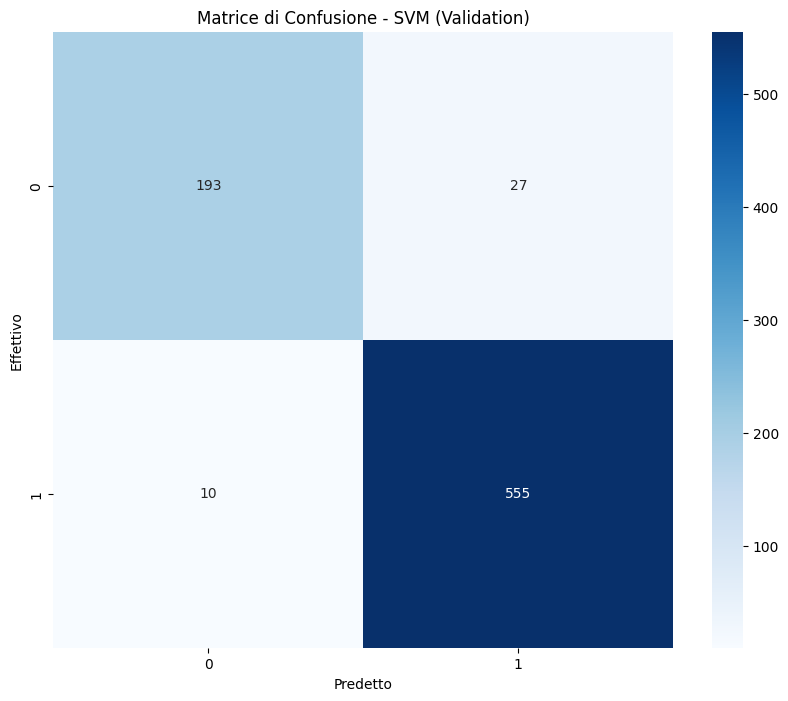

In [ ]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_validation, svm_pred), annot=True, fmt='g', cmap='Blues')
plt.title('Matrice di Confusione - SVM (Validation)')
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.show()

# **Random Forest**

Training a Random Forest model using scikit-learn in Python. Use the technique of exhaustive parameter search via GridSearchCV to optimize the model's accuracy.
After training, evaluate the model's performance using accuracy and calculate the RMSE (Root Mean Squared Error) as a measure of discrepancy between observed and predicted values. Finally, measure the processing time taken to train the model.

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # 42 is the seed
rf_param_grid = {'n_estimators': [100], 'max_depth': [None]}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')

# Training Random Forest
start_time = time.time()
rf_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
end_time = time.time()

# Considering which model is the best
rf_model_best = rf_grid_search.best_estimator_
rf_pred = rf_model_best.predict(X_validation.reshape(len(X_validation), -1))
rf_accuracy = accuracy_score(y_validation, rf_pred)

# RMSE
rf_rmse = mean_squared_error(y_validation, rf_pred, squared=False)

# Processing time
rf_processing_time = end_time - start_time

In [ ]:
print("Random Forest chosen:")
print(rf_model_best)
print("Accuracy Random Forest (validation):", rf_accuracy)
print("Confusion Matrix Random Forest:")
print(confusion_matrix(y_validation, rf_pred))
print("Classification Report Random Forest:")
print(classification_report(y_validation, rf_pred))

Random Forest chosen:
RandomForestClassifier(random_state=42)
Accuracy Random Forest (validation): 0.9426751592356688
Confusion Matrix Random Forest:
[[191  29]
 [ 16 549]]
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       220
           1       0.95      0.97      0.96       565

    accuracy                           0.94       785
   macro avg       0.94      0.92      0.93       785
weighted avg       0.94      0.94      0.94       785



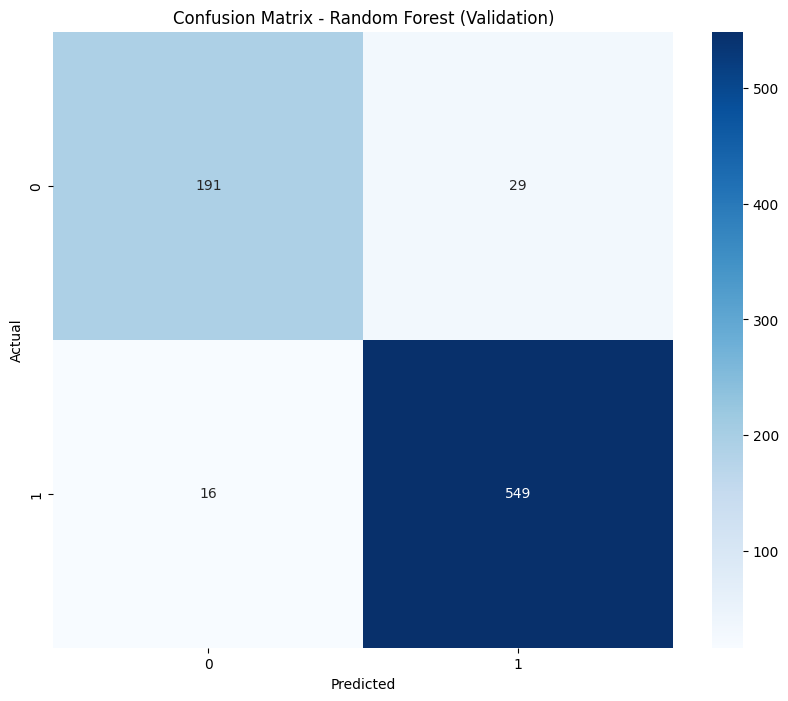

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_validation, rf_pred), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Convolutional Neural Network**

In [ ]:
# CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # 1 classe per la presenza/assenza di polmonite
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))
end_time = time.time()
y_pred_cnn = (model.predict(X_test) > 0.5).astype("int32")
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# Processing time
cnn_processing_time = end_time - start_time

Epoch 1/10
115/115 [==============================] - 5s 35ms/step - loss: 0.9978 - accuracy: 0.8626 - val_loss: 0.1615 - val_accuracy: 0.9401
Epoch 2/10
115/115 [==============================] - 6s 50ms/step - loss: 0.1564 - accuracy: 0.9410 - val_loss: 0.2363 - val_accuracy: 0.9172
Epoch 3/10
115/115 [==============================] - 4s 35ms/step - loss: 0.1772 - accuracy: 0.9255 - val_loss: 0.1637 - val_accuracy: 0.9452
Epoch 4/10
115/115 [==============================] - 4s 33ms/step - loss: 0.1490 - accuracy: 0.9399 - val_loss: 0.1398 - val_accuracy: 0.9452
Epoch 5/10
115/115 [==============================] - 5s 39ms/step - loss: 0.1212 - accuracy: 0.9536 - val_loss: 0.1729 - val_accuracy: 0.9389
Epoch 6/10
115/115 [==============================] - 5s 47ms/step - loss: 0.1123 - accuracy: 0.9560 - val_loss: 0.1299 - val_accuracy: 0.9541
Epoch 7/10
115/115 [==============================] - 4s 33ms/step - loss: 0.1257 - accuracy: 0.9519 - val_loss: 0.1234 - val_accuracy: 0.9580

In [ ]:
print("CNN:")
print("Accuracy CNN (test):", accuracy_cnn)
print("Confusion Matrix CNN:")
print(confusion_matrix(y_test, y_pred_cnn))
print("Classification Report CNN:")
print(classification_report(y_test, y_pred_cnn))

CNN:
Accuracy CNN (test): 0.9630573248407643
Confusion Matrix CNN:
[[179   8]
 [ 21 577]]
Classification Report CNN:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       187
           1       0.99      0.96      0.98       598

    accuracy                           0.96       785
   macro avg       0.94      0.96      0.95       785
weighted avg       0.96      0.96      0.96       785



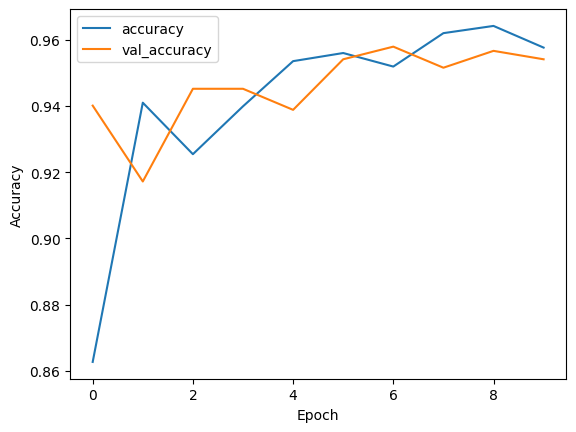

In [ ]:
# CNN accuracy during training
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Training CNN
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from keras import regularizers

# Adding some regularizers to the CNN
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Re-training the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))
cnn_accuracy = model.evaluate(X_test, y_test)[1]

In [ ]:
# Loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
corr_matrix = np.corrcoef(X.reshape(X.shape[0], -1))

# Correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Blues')
plt.title("Matrice di Correlazione delle Immagini")
plt.show()

In [ ]:
# Reducing image dimensionality
X_reshaped = X.reshape(X.shape[0], -1)  # Flatten images in vectors

# Cration of scatter matrix
plt.figure(figsize=(10, 8))
plt.scatter(X_reshaped[:, 0], X_reshaped[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Classe')
plt.xlabel('Pixel 1')
plt.ylabel('Pixel 2')
plt.title('Scatter Matrix delle Immagini')
plt.show()

In [ ]:
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Classe')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('Scatter Plot delle Immagini dopo PCA')
plt.show()


In [ ]:
models = ["SVM", "Random Forest", "CNN"]
accuracies = [svm_accuracy, rf_accuracy, cnn_accuracy]
processing_times = [svm_processing_time, rf_processing_time, cnn_processing_time]

results_data = {
    "Model": models,
    "Accuracy": accuracies,
    "Processing Time (s)": processing_times,
}

results_df = pd.DataFrame(results_data)

print("Results\n")
for index, row in results_df.iterrows():
    print(f"{row['Model']:20} | Accuracy: {row['Accuracy']:.4f} | Processing Time: {row['Processing Time (s)']:.2f} seconds")


# **Logistic regression**

In [ ]:
# Logistic regression model
logistic_model = LogisticRegression(random_state=42)
logistic_param_grid = {'C': [1.0]}  # param to optimize

logistic_grid_search = GridSearchCV(logistic_model, logistic_param_grid, cv=5, scoring='accuracy')

start_time = time.time()
logistic_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
end_time = time.time()

logistic_model_best = logistic_grid_search.best_estimator_
logistic_pred = logistic_model_best.predict(X_validation.reshape(len(X_validation), -1))
logistic_accuracy = accuracy_score(y_validation, logistic_pred)

# RMSE
logistic_rmse = mean_squared_error(y_validation, logistic_pred, squared=False)

# Processing time
logistic_processing_time = end_time - start_time

# Performance
print("Miglior modello di regressione logistica:")
print(logistic_model_best)
print("Accuracy regressione logistica (validation):", logistic_accuracy)
print("Confusion Matrix regressione logistica:")
print(confusion_matrix(y_validation, logistic_pred))
print("Classification Report regressione logistica:")
print(classification_report(y_validation, logistic_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Miglior modello di regressione logistica:
LogisticRegression(random_state=42)
Accuracy regressione logistica (validation): 0.9490445859872612
Confusion Matrix regressione logistica:
[[193  27]
 [ 13 552]]
Classification Report regressione logistica:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       220
           1       0.95      0.98      0.97       565

    accuracy                           0.95       785
   macro avg       0.95      0.93      0.94       785
weighted avg       0.95      0.95      0.95       785



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Reshape each image sample into a 1D array
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_flattened)

# Fit logistic regression model on reduced-dimensional data
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_pca, y_train)

# Define the mesh grid for the Cartesian map
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the labels for each point in the mesh grid
Z = logistic_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Logistic Regression Classifier with PCA')
plt.show()
